# Testing Mitiq ZNE in OpenQAOA

## 1. Creation of the graph + QUBO model

In [4]:
def create_graph(nodes,edges):
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
    return graph

In [11]:
import networkx as nx

from openqaoa.problems import MaximumCut
#Inner OpenQAOA function for ploting graphs
#plot_graph(graph)

# Create a MaximumCut instance from the graph and get its QUBO and hamiltonian
maxcut_prob = MaximumCut.random_instance(n_nodes = 10, edge_probability = 0.5)
print(maxcut_prob.problem_instance)
maxcut_qubo = maxcut_prob.qubo
maxcut_hamiltonian = maxcut_qubo.hamiltonian

{'problem_type': 'maximum_cut', 'G': {'directed': False, 'multigraph': False, 'graph': {}, 'nodes': [{'id': 0}, {'id': 1}, {'id': 2}, {'id': 3}, {'id': 4}, {'id': 5}, {'id': 6}, {'id': 7}, {'id': 8}, {'id': 9}], 'links': [{'source': 0, 'target': 3}, {'source': 0, 'target': 4}, {'source': 0, 'target': 5}, {'source': 0, 'target': 8}, {'source': 0, 'target': 9}, {'source': 1, 'target': 3}, {'source': 1, 'target': 6}, {'source': 1, 'target': 9}, {'source': 2, 'target': 6}, {'source': 2, 'target': 8}, {'source': 3, 'target': 5}, {'source': 4, 'target': 5}, {'source': 4, 'target': 8}, {'source': 4, 'target': 9}, {'source': 5, 'target': 7}, {'source': 5, 'target': 8}, {'source': 6, 'target': 7}]}}


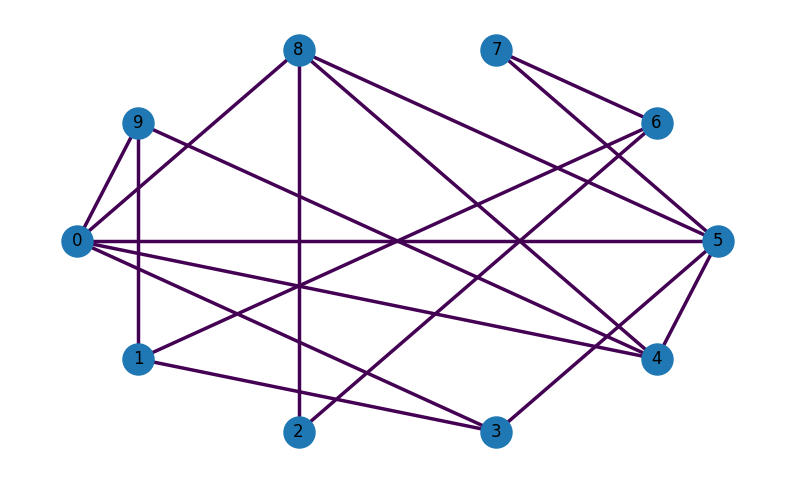

In [25]:
from openqaoa.utilities import plot_graph
plot_graph(maxcut_prob.G)

## 2.  OpenQAOA  

### 2.1. Configuration, compilation and optimization

In [76]:
from openqaoa import QAOA  
q1 = QAOA()
q1

In [77]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q1.set_device(qiskit_device)

q1.set_circuit_properties(p=4,param_type='standard', init_type='rand', mixer_hamiltonian='x')

q1.set_backend_properties(n_shots=5000, seed_simulator=1)

q1.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)


In [78]:
q1.compile(maxcut_qubo)

In [79]:
q1.optimize()

### 2.2. Results

states kept: 40


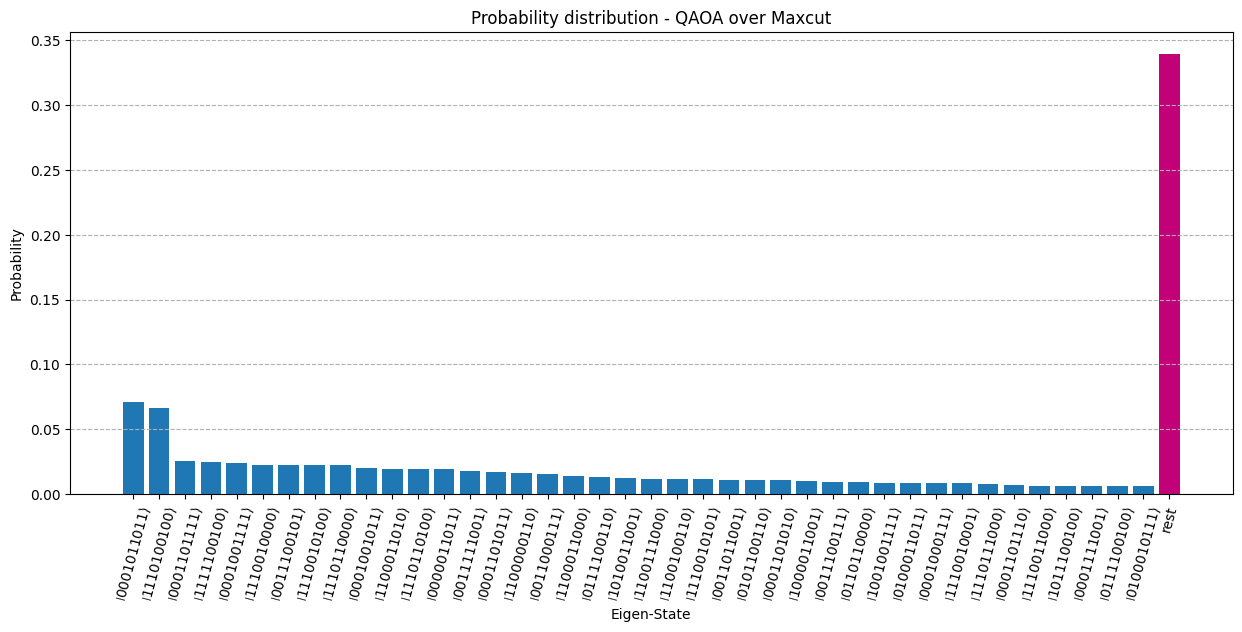

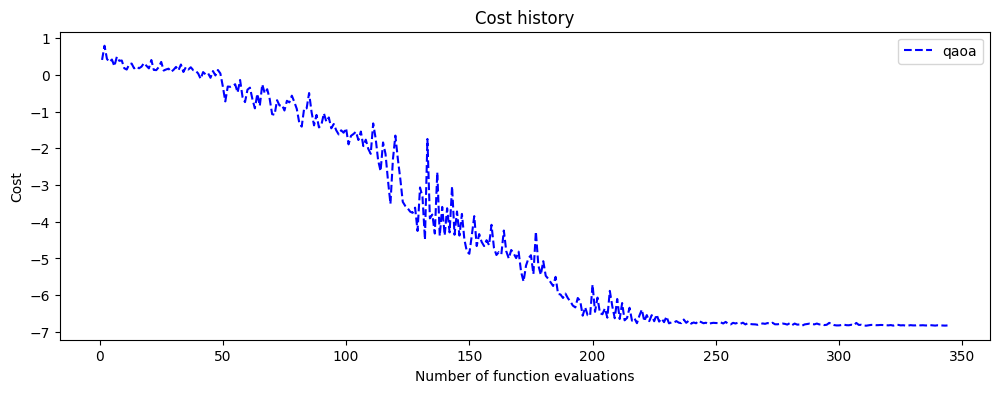

In [224]:
from openqaoa.utilities import ground_state_hamiltonian
correct_solution1 = ground_state_hamiltonian(q1.cost_hamil)
opt_results1 = q1.result

fig, ax = plt.subplots(figsize=(15,6))
opt_results1.plot_probabilities(ax=ax,label="Probability distribution - QAOA over Maxcut")
plt.savefig("qaoa_maxcut_probs.png",bbox_inches='tight')

fig, ax = plt.subplots(figsize=(12,4))
opt_results1.plot_cost(label='qaoa',ax=ax)
plt.savefig("qaoa_maxcut_cost.png",bbox_inches='tight')

## 3. OpenQAOA + noise

### 3.1 Adding a noise model

In [102]:
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['h','rx']
two_qubits_gates = ['rzz']

#create depol. noise
def add_depolarizing_error(noise_model,prob):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.05)

### 3.2. Configuration, compilation and optimization

In [112]:
from openqaoa import QAOA  
q2 = QAOA()
q2

In [113]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q2.set_device(qiskit_device)

q2.set_circuit_properties(p=4,param_type='standard', init_type='rand', mixer_hamiltonian='x')

q2.set_backend_properties(n_shots=5000, seed_simulator=1,
                          noise_model=noise_model
                         )

q2.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)


In [114]:
q2.compile(maxcut_qubo)

In [115]:
q2.optimize()

### 3.3 Results

states kept: 40


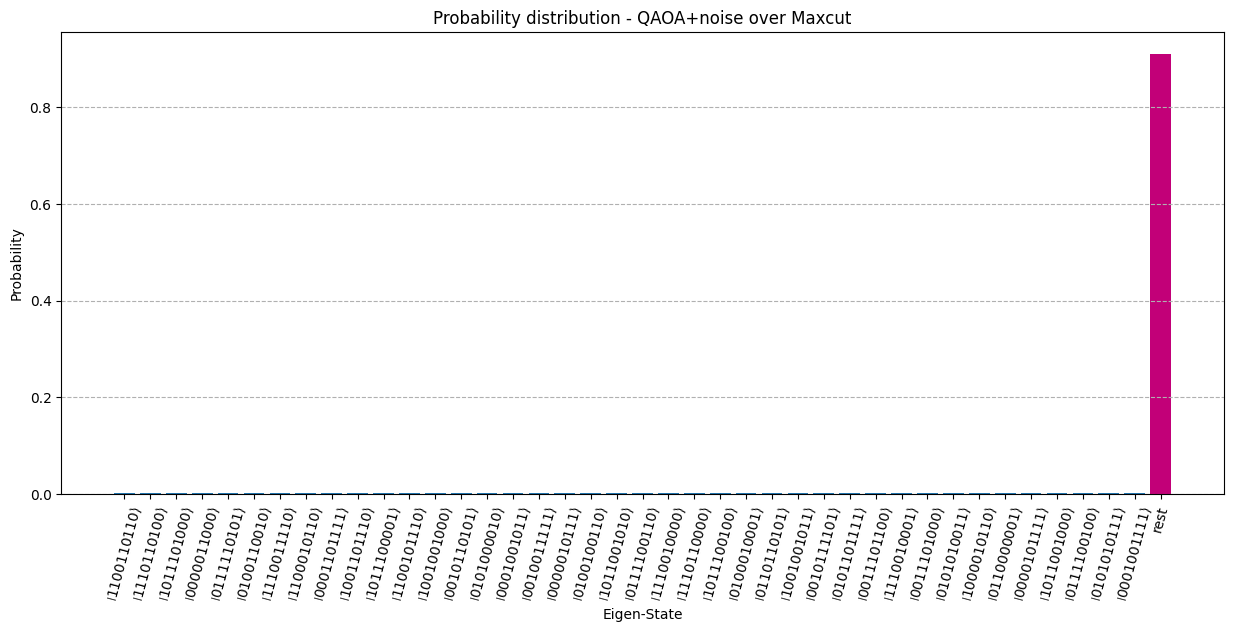

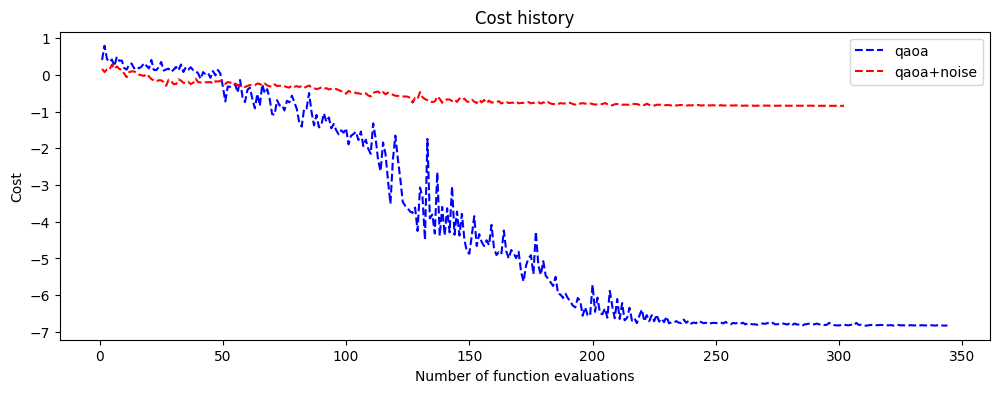

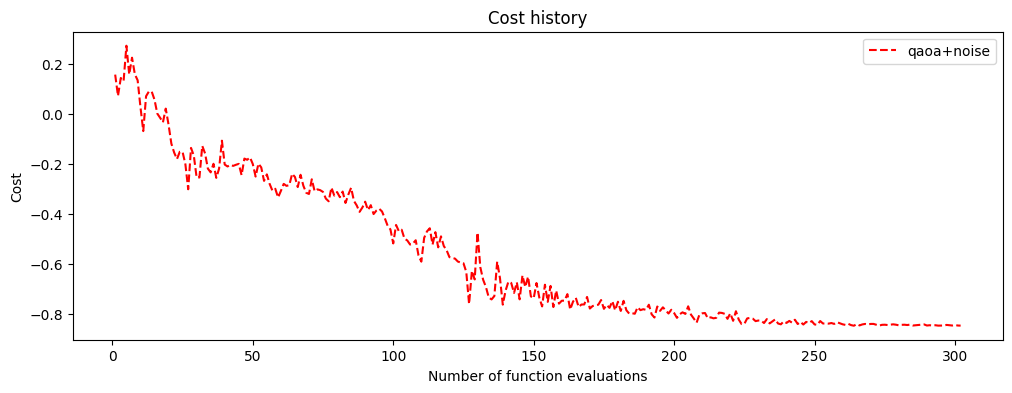

In [225]:
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
correct_solution2 = ground_state_hamiltonian(q2.cost_hamil)
opt_results2 = q2.result

fig, ax = plt.subplots(figsize=(15,6))
opt_results2.plot_probabilities(ax=ax,label='Probability distribution - QAOA+noise over Maxcut')
plt.savefig("qaoanoise_maxcut_probs.png", bbox_inches='tight')


fig, ax = plt.subplots(figsize=(12,4))
opt_results1.plot_cost(color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
plt.savefig("qaoa_qaoanoise_maxcut_cost.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(12,4))
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
plt.savefig("qaoanoise_maxcut_cost.png", bbox_inches='tight')


## 4. OpenQAOA + noise + ZNE

### 4.1. Configuration

In [122]:
from openqaoa import QAOA  
q3 = QAOA()
q3

In [123]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q3.set_device(qiskit_device)

q3.set_circuit_properties(p=4,param_type='standard', init_type='rand', mixer_hamiltonian='x')

q3.set_backend_properties(n_shots=5000, seed_simulator=1,
                          noise_model=noise_model
                         )
q3.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)


### 4.2. Adding ZNE technique

In [124]:
q3.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)

### 4.3. compilation and optimization

In [125]:
q3.compile(maxcut_qubo)

In [126]:
q3.optimize()

### 4.4 Results

states kept: 40


'\nfig, ax = plt.subplots(figsize=(15,6))\nopt_results2.plot_probabilities(ax=ax,label=\'Probability distribution - QAOA+noise over Maxcut\')\n#plt.savefig("qaoanoise_qaoazne_maxcut_probs.png")\n\n\nopt_results1.plot_cost(color=\'blue\',label=\'qaoa\',ax=ax)\nopt_results2.plot_cost(color=\'red\',label=\'qaoa+noise\',ax=ax)\n\nfig, ax = plt.subplots(figsize=(12,4))\nopt_results2.plot_cost(color=\'red\',label=\'qaoa+noise\',ax=ax)\n#plt.savefig("qaoanoise_maxcut_cost.png")'

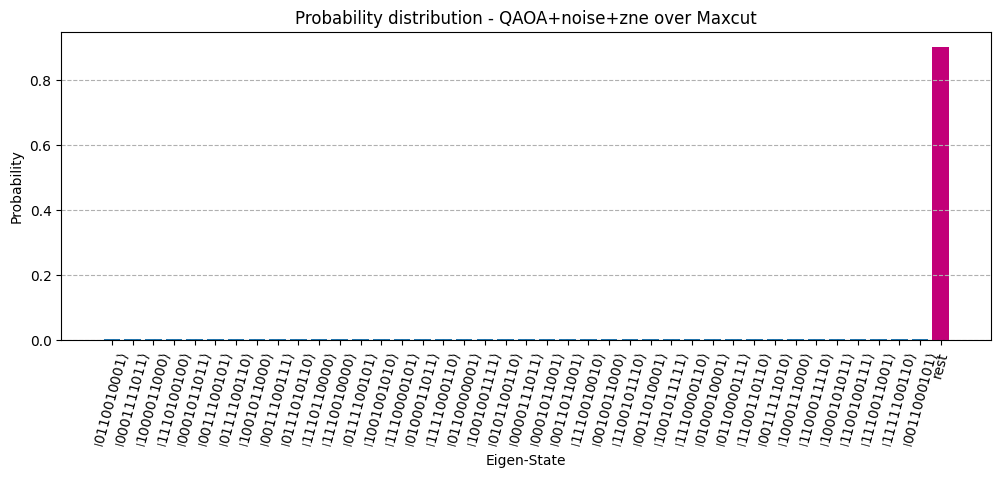

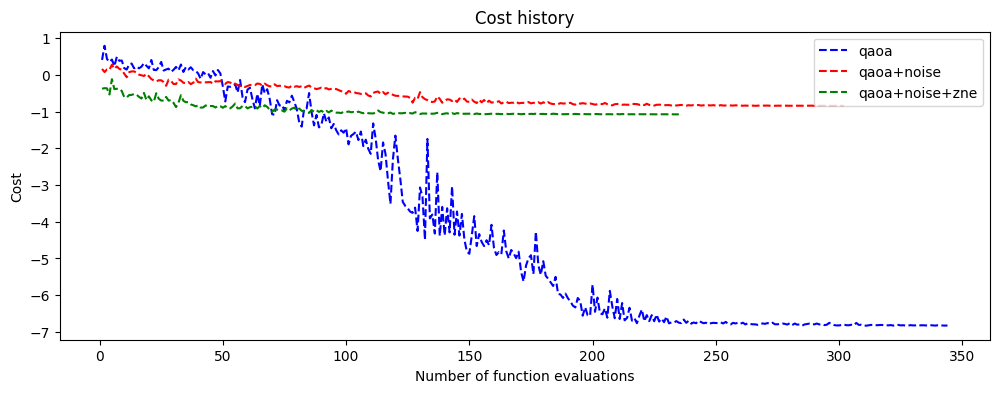

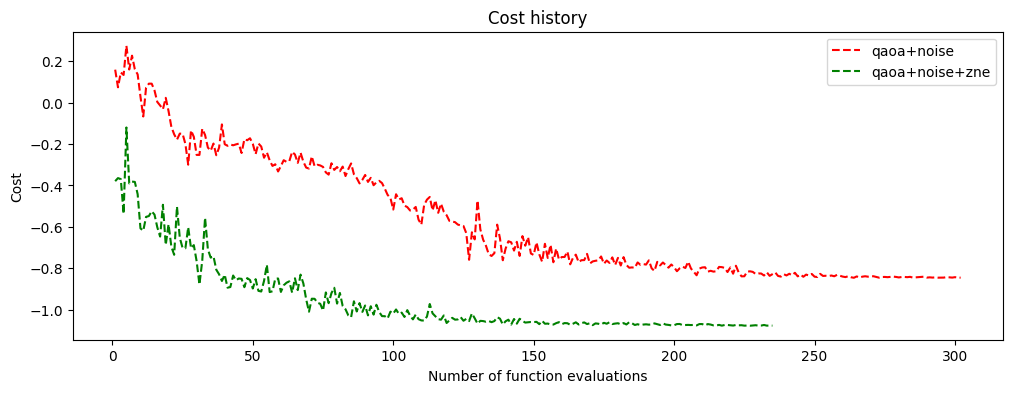

In [230]:
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
correct_solution3 = ground_state_hamiltonian(q3.cost_hamil)
opt_results3 = q3.result

fig, ax = plt.subplots(figsize=(12,4))
opt_results3.plot_probabilities(ax=ax,label='Probability distribution - QAOA+noise+zne over Maxcut')
#plt.savefig("qaoazne_maxcut_probs.png",bbox_inches='tight')

fig, ax = plt.subplots(figsize=(12,4))
opt_results1.plot_cost(color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
opt_results3.plot_cost(color='green',label='qaoa+noise+zne',ax=ax)
#plt.savefig("qaoa_qaoanoise_qaoazne_maxcut_cost.png",bbox_inches='tight')

fig, ax = plt.subplots(figsize=(12,4))
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
opt_results3.plot_cost(color='green',label='qaoa+noise+zne',ax=ax)
plt.savefig("qaoanoise_qaoazne_maxcut_cost.png",bbox_inches='tight')

'''
fig, ax = plt.subplots(figsize=(15,6))
opt_results2.plot_probabilities(ax=ax,label='Probability distribution - QAOA+noise over Maxcut')
#plt.savefig("qaoanoise_qaoazne_maxcut_probs.png")


opt_results1.plot_cost(color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)

fig, ax = plt.subplots(figsize=(12,4))
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
#plt.savefig("qaoanoise_maxcut_cost.png")'''

## 5. Variable depolarizing noise over OpenQAOA+noise and OpenQAOA+noise+zne

In [177]:
def execute_qaoa(noise_model=None,mitigate = False):
    #runs a qaoa an returns its result. Mitigate boolean indicates if zne should be applied.
    q_aux = QAOA()
    
    qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
    q_aux.set_device(qiskit_device)

    q_aux.set_circuit_properties(p=4,param_type='standard', init_type='rand', mixer_hamiltonian='x')

    q_aux.set_backend_properties(n_shots=5000, seed_simulator=1,
                          noise_model=noise_model
                         )
    q_aux.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                            optimization_progress=True, cost_progress=True, parameter_log=True)

    if mitigate:
        q_aux.set_error_mitigation_properties(
        error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
        )
    q_aux.compile(maxcut_qubo)
    q_aux.optimize()
        
    return q_aux.result


In [183]:
#ALL THE NOISE PROBABILITIES TO TRY
noise_probs = []
for i in range(0,50,5):
    noise_probs.append(i/100)
#print(noise_probs)

#GET THE CORRECT RESULT(BRUTE FORCE SOLVING)
correct_result = ground_state_hamiltonian(q1.cost_hamil)[1]
print('CORRECT RESULT: ',correct_result)

#GET THE IDEAL EXPECTATION VALUE
ideal_result = opt_results1
measurement_outcomes = ideal_result.optimized.get('measurement_outcomes')
#print(measurement_outcomes)
ideal_expectation_value=0
for result in correct_result:
    ideal_expectation_value += measurement_outcomes.get(result)
    #print( measurement_outcomes.get(result))
ideal_expectation_value = ideal_expected_value / 5000
print('IDEAL EXPECTATION VALUE: ',ideal_expected_value)

noisyresults_errors = []
mitigatedresults_errors=[]
#ITERATE OVER THE DIFERENTE NOISE PROBABILITIES
for noise_prob in noise_probs:
    print('NOISE PROB ',noise_prob)
    noise_model = add_depolarizing_error(NoiseModel(),noise_prob)

    #CALCULATE NOISY EXPECTATION VALUE AND NOISY ERROR
    noisy_result = execute_qaoa(noise_model,False)
    print('noisy result calculated')
    noisy_measurement_outcomes = noisy_result.optimized.get('measurement_outcomes')
    noisy_expectation_value=0
    for result in correct_result:
        print( noisy_measurement_outcomes.get(result))
        noisy_expectation_value += noisy_measurement_outcomes.get(result)
    noisy_expectation_value = noisy_expectation_value / 5000
    noisyresults_errors.append(abs(ideal_expectation_value-noisy_expectation_value))

    #CALCULATE MITIGATED EXPECTATION VALUE AND MITIGATED ERROR
    mitigated_result = execute_qaoa(noise_model,True)
    print('mitigated result calculated')
    mitigated_measurement_outcomes = mitigated_result.optimized.get('measurement_outcomes')
    mitigated_expectation_value=0
    for result in correct_result:
        mitigated_expectation_value += mitigated_measurement_outcomes.get(result)
        #print( mitigated_measurement_outcomes.get(result))
    mitigated_expectation_value = mitigated_expectation_value / 5000
    mitigatedresults_errors.append(abs(ideal_expectation_value-mitigated_expectation_value))

CORRECT RESULT:  ['1110100100', '0001011011']
IDEAL EXPECTATION VALUE:  0.1376
NOISE PROB  0.0
noisy result calculated
155
173
mitigated result calculated
NOISE PROB  0.05
noisy result calculated
15
14
mitigated result calculated
NOISE PROB  0.1
noisy result calculated
2
7
mitigated result calculated
NOISE PROB  0.15
noisy result calculated
4
1
mitigated result calculated
NOISE PROB  0.2
noisy result calculated
4
1
mitigated result calculated
NOISE PROB  0.25
noisy result calculated
4
1
mitigated result calculated
NOISE PROB  0.3
noisy result calculated
4
1
mitigated result calculated
NOISE PROB  0.35
noisy result calculated
4
1
mitigated result calculated
NOISE PROB  0.4
noisy result calculated
4
1
mitigated result calculated
NOISE PROB  0.45
noisy result calculated
4
1
mitigated result calculated


'\nfig, ax = plt.subplots(figsize=(15,6))\nopt_results2.plot_probabilities(ax=ax,label=\'Probability distribution - QAOA+noise over Maxcut\')\n#plt.savefig("qaoanoise_qaoazne_maxcut_probs.png")\n\n\nopt_results1.plot_cost(color=\'blue\',label=\'qaoa\',ax=ax)\nopt_results2.plot_cost(color=\'red\',label=\'qaoa+noise\',ax=ax)\n\nfig, ax = plt.subplots(figsize=(12,4))\nopt_results2.plot_cost(color=\'red\',label=\'qaoa+noise\',ax=ax)\n#plt.savefig("qaoanoise_maxcut_cost.png")'

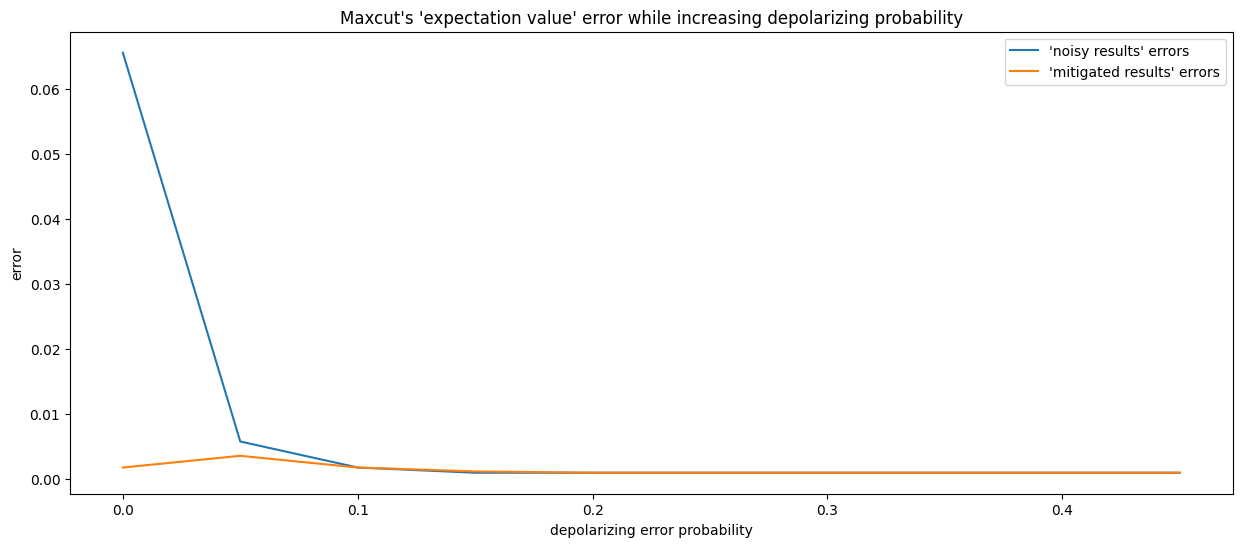

In [237]:
plt.figure(figsize=(15,6))
plt.plot(noise_probs,noisyresults_errors,label='\'noisy results\' errors')
plt.plot(noise_probs,mitigatedresults_errors,label='\'mitigated results\' errors')

plt.title('Maxcut\'s \'expectation value\' error while increasing depolarizing probability')
plt.xlabel('depolarizing error probability')
plt.ylabel('error')

plt.legend()

'''
fig, ax = plt.subplots(figsize=(15,6))
opt_results2.plot_probabilities(ax=ax,label='Probability distribution - QAOA+noise over Maxcut')
#plt.savefig("qaoanoise_qaoazne_maxcut_probs.png")


opt_results1.plot_cost(color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)

fig, ax = plt.subplots(figsize=(12,4))
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
#plt.savefig("qaoanoise_maxcut_cost.png")'''

In [13]:
q.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q.set_circuit_properties(p=2)
q.set_backend_properties(n_shots=10000, seed_simulator=1, noise_model = noise_model)

q.compile(maxcut_qubo)

## Optimization

In [14]:
q.optimize()

## Getting the solution

In [15]:
from openqaoa.utilities import ground_state_hamiltonian
correct_solution = ground_state_hamiltonian(q.cost_hamil)
correct_solution

(-3.0,
 ['10100', '10010', '01010', '11010', '00101', '10101', '01101', '01011'])

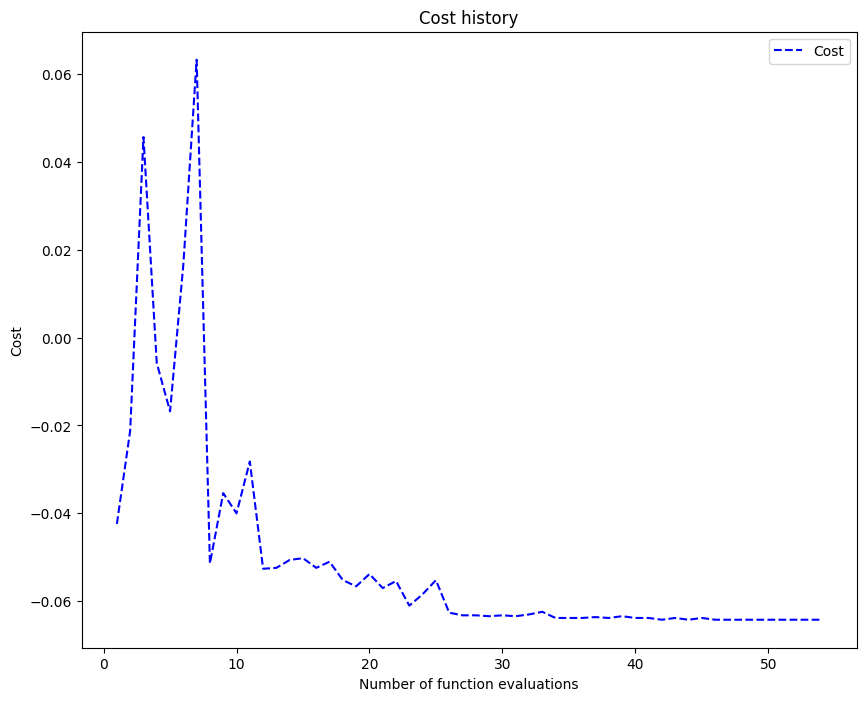

In [16]:
opt_results = q.result
opt_results.plot_cost()


## Comparing with standard QAOA, with noise

In [30]:
q1 = QAOA()
q1.set_device(qiskit_device)

noise_model = add_depolarizing_error(NoiseModel(),0.3)
q1.set_circuit_properties(p=2)
q1.set_backend_properties(n_shots=10000, seed_simulator=1, noise_model = noise_model)

""" q1.set_backend_properties(n_shots=1024, seed_simulator=1, noise_model = noise_model) """

q1.compile(maxcut_qubo)

In [31]:
q1.optimize()

In [32]:
correct_solution = ground_state_hamiltonian(q1.cost_hamil)
correct_solution

(-3.0,
 ['10100', '10010', '01010', '11010', '00101', '10101', '01101', '01011'])

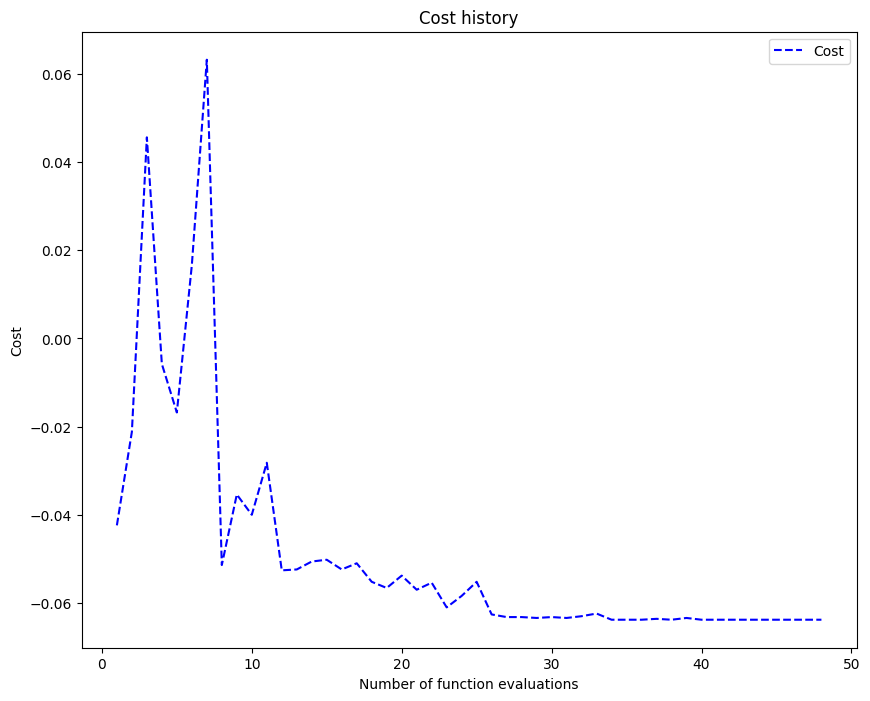

In [33]:
opt_results = q1.result
opt_results.plot_cost()

## Comparing with standard QAOA, with IBM Quantum backend

In [5]:
from qiskit import IBMQ
from openqaoa import create_device
from qiskit_ibm_provider import IBMProvider

In [36]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
ibm_device = create_device(location='ibmq', 
                                name='ibm_osaka',
                                hub='ibm-q', 
                                group='open', 
                                project='main')

In [14]:
q2 = QAOA()
q2.set_device(ibm_device)
q2.compile(maxcut_qubo)

In [15]:
q2.optimize()

KeyboardInterrupt: 

In [ ]:
correct_solution = ground_state_hamiltonian(q2.cost_hamil)
correct_solution

## Comparing with OpenQAOA + Mitiq ZNE, with IBM Quantum backend

In [7]:
q3 = QAOA()
q3.set_device(ibm_device)
q3.set_backend_properties(n_shots=1024, seed_simulator=1)
q3.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q3.compile(maxcut_qubo)

In [8]:
q3.optimize()

TranspilerError: "The number of qubits for Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]) does not match the number of qubits in the properties dictionary: (0,)"

In [ ]:
correct_solution = ground_state_hamiltonian(q3.cost_hamil)
correct_solution

In [8]:
from openqaoa.backends.qaoa_backend import (
    DEVICE_NAME_TO_OBJECT_MAPPER,
    DEVICE_ACCESS_OBJECT_MAPPER,
)

In [9]:
print(DEVICE_NAME_TO_OBJECT_MAPPER.keys())

dict_keys(['vectorized', 'analytical_simulator', 'qiskit.qasm_simulator', 'qiskit.shot_simulator', 'qiskit.statevector_simulator'])
